Prepare the Environment

In [ ]:
# Install required libraries
!pip install -U kaleido # for saving graphs
!pip install --upgrade plotly>=6.1.1 # make it compatible with kaleido

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from tensorflow.keras import Input, Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import joblib
import plotly.io as pio
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError, MeanAbsolutePercentageError
import os
import pickle
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import backend as K

Set-up some useufle functions

In [ ]:
# @title Filling missing values and return a dateframe with 'Date' as index

def fill_missing_dates(df, date_column='date'):
    df[date_column] = pd.to_datetime(df[date_column])
    df = df.set_index(date_column).sort_index()

    # Reindex to continuous daily frequency
    full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
    df = df.reindex(full_range)

    # interpolate missing values
    df.interpolate(method='linear', inplace=True)

    # Rename the index for clarity (optional)
    df.index.name = date_column

    return df

In [ ]:
# @title Defining create_sequences (for single feature) function
def create_sequences(data, window_size=30, horizon=30): # window_size=30: Use last 30 days of data as input/horizon=30: Predict the price 30 day into the future
    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size+horizon-1])
    return np.array(X), np.array(y)

In [ ]:
# @title Defining create_sequences_multifeature function and inverse

def create_sequences_multifeature(data, window_size=30, horizon=30):
    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size+horizon-1][0])  # <== ONLY take the first feature
    return np.array(X), np.array(y)


def inverse_single_feature(scaler, y_scaled, feature_index=0, total_features=3):
    """
    Inverse transform a single target feature from a scaler trained on multiple features.

    Parameters:
    - scaler: the fitted MinMaxScaler or StandardScaler
    - y_scaled: 1D array of scaled target values
    - feature_index: index of the feature to place into the dummy matrix (default: 0)
    - total_features: number of features originally fit in scaler

    Returns:
    - 1D array of inverse-transformed values
    """
    y_scaled = np.asarray(y_scaled).flatten()  # ✅ works with both NumPy and TensorFlow
    dummy = np.zeros((len(y_scaled), total_features))
    dummy[:, feature_index] = y_scaled
    return scaler.inverse_transform(dummy)[:, feature_index]

In [ ]:
# @title Defining evaluation matrics forecast_metrics
def forecast_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    return {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R²": r2
    }

In [ ]:
# Path to saved results
results_path = '/content/drive/My Drive/BKW/Models/PVB/results_df_pvb_models.csv'

if os.path.exists(results_path):
    results_df = pd.read_csv(results_path)
else:
    results_df = pd.DataFrame(columns=['Label', 'MAE', 'MSE', 'RMSE', 'R2', 'cutoff_date', 'features'])

In [ ]:
# @title Defining an model evalutation function
def evaluation_metrics(y_true, y_pred, label='', cutoff_date=None, features=None, results_df=None, save_path=None):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"{label:<30} | MAE: {mae:>6.3f}  MSE: {mse:>6.3f}  RMSE: {rmse:>6.3f}  R²: {r2:>6.3f}")

    # Check for existing entry to avoid duplicates
    if results_df is not None:
        exists = ((results_df['Label'] == label) & (results_df['cutoff_date'] == str(cutoff_date))).any()
        if not exists:
            features_str = ', '.join(features) if isinstance(features, list) else str(features)
            results_df.loc[len(results_df)] = [label, mae, mse, rmse, r2, cutoff_date, features_str]
            if save_path:
                results_df.to_csv(save_path, index=False)

    return results_df

In [ ]:
# @title Defining a plotting function for the traning history
def plot_loss(history):
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# @title Defining a plotting function to plot the historical data, actual and predicted price on the forecasting date
def plot_lstm_forecast_aligned_to_forecast_date(
    df_all,
    forecast_dates,
    y_pred_inv,
    y_true_inv,
    horizon_days,
    title='Price Forecast (Aligned to Forecast Date)',
    save_path=None,   # e.g., '/content/drive/My Drive/BKW/reports'
    save_format='png' # 'png', 'pdf', 'svg', etc. (requires kaleido)
):
    """
    Plots historical  prices, and shows predicted & actual target prices on the forecast date.

    Parameters:
    - df_all: DataFrame with 'PVB_Price' and datetime index (historical)
    - forecast_dates: dates when forecasts were made
    - y_pred_inv: predicted prices for target dates (already inverse-transformed)
    - y_true_inv: actual target prices (already inverse-transformed)
    - horizon_days: how far ahead the forecast is (e.g., 30 for 1-month)
    - title: chart title
    - save_path: full file path to save the plot (optional)
    - save_format: file format (default 'png')

    Returns:
    - fig: the plotly figure object
    """

    # Convert inputs to pandas Series for indexing
    forecast_dates = pd.to_datetime(forecast_dates)
    y_pred_series = pd.Series(y_pred_inv.flatten(), index=forecast_dates)

    # Shift actual target values back to the forecast date
    actual_target_dates = forecast_dates + pd.Timedelta(days=horizon_days)
    y_true_series = pd.Series(y_true_inv.flatten(), index=actual_target_dates)
    y_true_aligned = y_true_series.shift(-horizon_days, freq='D')  # move back to forecast date

    # Start building the plot
    fig = go.Figure()

    # Historical TTF price
    fig.add_trace(go.Scatter(
        x=df_all.index,
        y=df_all['PVB'],
        mode='lines',
        name='Historical Price',
        line=dict(color='lightgray'),
        opacity=0.5
    ))

    # Predicted target prices (plotted on forecast date)
    fig.add_trace(go.Scatter(
        x=y_pred_series.index,
        y=y_pred_series.values,
        mode='lines+markers',
        name=f'Predicted price (+{horizon_days}D)',
        marker=dict(size=2.5),
        line=dict(color='orange')
    ))

    # Actual future prices aligned to forecast date
    fig.add_trace(go.Scatter(
        x=y_true_aligned.index,
        y=y_true_aligned.values,
        mode='lines+markers',
        name=f'Actual price (+{horizon_days}D)',
        marker=dict(size=2.5),
        line=dict(color='blue')
    ))

    # Layout
    fig.update_layout(
        title=title,
        xaxis_title='Forecast Date',
        yaxis_title='HenryHub_Price ($/MMBtu)',
        hovermode='x unified',
        xaxis=dict(tickangle=-45),
        height=600
    )

    fig.show()

    # Optionally save the plot
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        fig.write_image(save_path, format=save_format)
        print(f"✅ Plot saved to: {save_path}")

    return fig

In [ ]:
#@title Function to Save Model and Training History
import os
import pickle

def save_model_and_history(model, history, save_dir, model_name='lstm_model'):
    """
    Saves a Keras model and its training history to the specified directory.

    Parameters:
    - model: trained Keras model
    - history: result of model.fit()
    - save_dir: directory path (e.g., '/content/drive/My Drive/LNG_Forecasts/')
    - model_name: base name for saved files (default: 'lstm_model')
    """
    os.makedirs(save_dir, exist_ok=True)

    # Save model
    model_path = os.path.join(save_dir, f'{model_name}.keras')
    model.save(model_path)

    # Save history
    history_path = os.path.join(save_dir, f'{model_name}_history.pkl')
    with open(history_path, 'wb') as f:
        pickle.dump(history.history, f)

    print(f"✅ Model saved to: {model_path}")
    print(f"✅ History saved to: {history_path}")

In [ ]:
#@title Function to Load Model and Training History
import os
import pickle
from tensorflow.keras.models import load_model

def load_model_and_history(save_dir, model_name='lstm_model'):
    """
    Loads a saved Keras model and optionally its training history.

    Parameters:
    - save_dir: Directory path
    - model_name: Base name used when saving

    Returns:
    - model: Loaded Keras model
    - history: Training history (as a dict), or None if not found
    """
    # Load model
    model_path = os.path.join(save_dir, f'{model_name}.keras')
    model = load_model(model_path)
    print(f"✅ Model loaded from: {model_path}")

    # Attempt to load history
    history_path = os.path.join(save_dir, f'{model_name}_history.pkl')
    history = None
    if os.path.exists(history_path):
        try:
            with open(history_path, 'rb') as f:
                history = pickle.load(f)
            print(f"✅ History loaded from: {history_path}")
        except Exception as e:
            print(f"⚠️ Error loading history: {e}")
    else:
        print(f"⚠️ History file not found at: {history_path}")

    return model, history

In [ ]:
# @title Defining a function to save the forecast results
def save_lstm_forecast_results_full(
    forecast_dates,
    features_df,
    y_pred_inv,
    y_true_inv,
    horizon_days,
    save_path=None
):
    """
    Adds predicted and actual prices to a full-length feature DataFrame, aligned by forecast date.

    Parameters:
    - forecast_dates: list of forecast dates (len = N)
    - features_df: full-length DataFrame with datetime index (len = M)
    - y_pred_inv: predicted values (N,)
    - y_true_inv: actual values (N,)
    - horizon_days: forecast horizon (used in column naming)
    - save_path: optional file path to save

    Returns:
    - DataFrame with added columns for predictions and true values
    """
    forecast_dates = pd.to_datetime(forecast_dates)

    # Create aligned series
    y_pred_series = pd.Series(y_pred_inv.flatten(), index=forecast_dates)
    actual_target_dates = forecast_dates + pd.Timedelta(days=horizon_days)
    y_true_series = pd.Series(y_true_inv.flatten(), index=actual_target_dates)
    y_true_aligned = y_true_series.shift(-horizon_days, freq='D')

    # Copy and assign predictions into matching rows
    df_result = features_df.copy()

    df_result[f'Predicted_{horizon_days}D'] = pd.NA
    df_result[f'Actual_{horizon_days}D'] = pd.NA

    # Assign only where we have predictions
    df_result.loc[y_pred_series.index, f'Predicted_{horizon_days}D'] = y_pred_series
    df_result.loc[y_true_aligned.index, f'Actual_{horizon_days}D'] = y_true_aligned

    # Save if path is given
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        df_result.to_csv(save_path)
        print(f"✅ Forecast results saved to: {save_path}")

    return df_result

# Load data and basic EDA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = '/content/drive/MyDrive/BKW/LNG Project data/' # if running this notebook in colab
# data_path = '../../data/LNG Project data/' # if running this notebook locally

file_path = 'DATA from 2009 (on progress)/Newest_Raw_18_07.csv'
# Load and prepare data
df_all = pd.read_csv(data_path + file_path)
df_all.head()

,Date,Brent_Price,JKM_Price,Coal_Price,HH_Price,TTF_Price,Temp_Global,Temp_Southern_Hemisphere,Temp_Northern_Hemisphere,NetImports_Total,...,LNG_on_water_Africa,LNG_on_water_Europe,LNG_on_water_Americas,TTFMc1,TTFMc2,TTFMc3,TTFMc4,TTFMc5,TTFMc6,PVB
0,2009-01-01,NaN,NaN,NaN,NaN,21.00,12.580,15.963,9.254,694352.0,...,NaN,NaN,NaN,21.45,21.00,21.80,17.48,NaN,NaN,NaN
1,2009-01-02,46.91,NaN,74.35,5.41,22.20,12.503,15.952,9.109,27910.0,...,NaN,NaN,NaN,20.15,19.96,18.25,16.65,NaN,NaN,NaN
2,2009-01-03,NaN,NaN,NaN,NaN,NaN,12.442,16.003,8.938,-14882.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2009-01-04,NaN,NaN,NaN,NaN,NaN,12.416,16.097,8.792,-193166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2009-01-05,49.62,NaN,77.65,5.83,22.85,12.432,16.191,8.730,64498.0,...,NaN,NaN,NaN,20.75,20.54,18.11,17.29,NaN,NaN,NaN


In [ ]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6043 entries, 0 to 6042
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Date                      6043 non-null   object 
 1   Brent_Price               4265 non-null   float64
 2   JKM_Price                 2802 non-null   float64
 3   Coal_Price                4233 non-null   float64
 4   HH_Price                  4162 non-null   float64
 5   TTF_Price                 4246 non-null   float64
 6   Temp_Global               6026 non-null   float64
 7   Temp_Southern_Hemisphere  6026 non-null   float64
 8   Temp_Northern_Hemisphere  6026 non-null   float64
 9   NetImports_Total          6031 non-null   float64
 10  Inventories_Global        3109 non-null   float64
 11  pipe_Norway               2421 non-null   float64
 12  pipe_Algeria              2421 non-null   float64
 13  pipe_Russia               2421 non-null   float64
 14  pipe_Aze

In [ ]:
df_all.columns

Index(['Date', 'Brent_Price', 'JKM_Price', 'Coal_Price', 'HH_Price',
       'TTF_Price', 'Temp_Global', 'Temp_Southern_Hemisphere',
       'Temp_Northern_Hemisphere', 'NetImports_Total', 'Inventories_Global',
       'pipe_Norway', 'pipe_Algeria', 'pipe_Russia', 'pipe_Azerbaijan',
       'pipe_Libya', 'pipe_UK', 'pipe_LNG', 'pipe_EU total',
       'pipe_Nord Stream', 'pipe_Ukraine', 'pipe_Yamal', 'pipe_Turkstream',
       'LNG_on_water_Asia', 'LNG_on_water_Unknown', 'LNG_on_water_Africa',
       'LNG_on_water_Europe', 'LNG_on_water_Americas', 'TTFMc1', 'TTFMc2',
       'TTFMc3', 'TTFMc4', 'TTFMc5', 'TTFMc6', 'PVB'],
      dtype='object')

In [ ]:
#@ plot some columns in original unit
# cols_to_plot = ['HenryHub_Price']

cols_to_plot = ['PVB', 'Brent_Price', 'Coal_Price', 'HH_Price','JKM_Price', 'TTF_Price']

fig = go.Figure()
for col in cols_to_plot:
    fig.add_trace(go.Scatter(x=df_all['Date'], y=df_all[col], mode='lines', name=col))

fig.update_layout(
    title='Energy Price Trends (in original unit)',
    xaxis_title='Date',
    yaxis_title='various units',
    xaxis=dict(tickformat='%Y-%m', tickangle=-45, dtick="M3", tickfont=dict(size=8)),
    yaxis=dict(tickfont=dict(size=10)),
    hovermode='x unified',
    height=600
)
fig.show()

In [ ]:
# Columns to plot
# cols_to_plot = ['HenryHub_Price']

cols_to_plot = ['PVB', 'Brent_Price', 'Coal_Price', 'HH_Price','JKM_Price', 'TTF_Price']

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_all[cols_to_plot]), columns=cols_to_plot)
df_scaled['Date'] = df_all['Date']

fig = go.Figure()
for col in cols_to_plot:
    fig.add_trace(go.Scatter(x=df_scaled['Date'], y=df_scaled[col], mode='lines', name=col))

fig.update_layout(
    title='Normalized Energy Price Trends (Scaled)',
    xaxis_title='Date',
    yaxis_title='Scaled Value',
    xaxis=dict(tickformat='%Y-%m', tickangle=-45, dtick="M3", tickfont=dict(size=8)),
    yaxis=dict(tickfont=dict(size=10)),
    hovermode='x unified',
    height=600
)
fig.show()

In [ ]:
df_selected_features = df_all[['Date','PVB',
 'Brent_Price', 'JKM_Price', 'Coal_Price', 'HH_Price',
       'TTF_Price', 'NetImports_Total', 'Inventories_Global',
       'pipe_EU total','TTFMc1', 'TTFMc2',
       'TTFMc3', 'TTFMc4', 'TTFMc5', 'TTFMc6']].copy()
df_selected_features.head()

,Date,PVB,Brent_Price,JKM_Price,Coal_Price,HH_Price,TTF_Price,NetImports_Total,Inventories_Global,pipe_EU total,TTFMc1,TTFMc2,TTFMc3,TTFMc4,TTFMc5,TTFMc6
0,2009-01-01,NaN,NaN,NaN,NaN,NaN,21.00,694352.0,NaN,NaN,21.45,21.00,21.80,17.48,NaN,NaN
1,2009-01-02,NaN,46.91,NaN,74.35,5.41,22.20,27910.0,NaN,NaN,20.15,19.96,18.25,16.65,NaN,NaN
2,2009-01-03,NaN,NaN,NaN,NaN,NaN,NaN,-14882.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2009-01-04,NaN,NaN,NaN,NaN,NaN,NaN,-193166.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2009-01-05,NaN,49.62,NaN,77.65,5.83,22.85,64498.0,NaN,NaN,20.75,20.54,18.11,17.29,NaN,NaN


In [ ]:
df_selected_features = fill_missing_dates(df_selected_features, 'Date')
df_selected_features.head()

,PVB,Brent_Price,JKM_Price,Coal_Price,HH_Price,TTF_Price,NetImports_Total,Inventories_Global,pipe_EU total,TTFMc1,TTFMc2,TTFMc3,TTFMc4,TTFMc5,TTFMc6
Date,,,,,,,,,,,,,,,
2009-01-01,NaN,NaN,NaN,NaN,NaN,21.000000,694352.0,NaN,NaN,21.45,21.000000,21.800000,17.480000,NaN,NaN
2009-01-02,NaN,46.910000,NaN,74.35,5.41,22.200000,27910.0,NaN,NaN,20.15,19.960000,18.250000,16.650000,NaN,NaN
2009-01-03,NaN,47.813333,NaN,75.45,5.55,22.416667,-14882.0,NaN,NaN,20.35,20.153333,18.203333,16.863333,NaN,NaN
2009-01-04,NaN,48.716667,NaN,76.55,5.69,22.633333,-193166.0,NaN,NaN,20.55,20.346667,18.156667,17.076667,NaN,NaN
2009-01-05,NaN,49.620000,NaN,77.65,5.83,22.850000,64498.0,NaN,NaN,20.75,20.540000,18.110000,17.290000,NaN,NaN


In [ ]:
#@title adding some technical features
df_selected_features['month'] = df_selected_features.index.month  # Integer (1–12)
df_selected_features['sin_day'] = np.sin(2 * np.pi * df_selected_features.index.dayofyear / 365.25)
df_selected_features['cos_day'] = np.cos(2 * np.pi * df_selected_features.index.dayofyear / 365.25)
df_selected_features['PVB_Return'] = df_selected_features['PVB'].pct_change()
df_selected_features['MA_7'] = df_selected_features['PVB'].rolling(7).mean()
df_selected_features['Volatility_30'] = df_selected_features['PVB'].rolling(30).std()
df_selected_features['return_30'] = df_selected_features['PVB'].pct_change(30)
df_selected_features['return_60'] = df_selected_features['PVB'].pct_change(60)
df_selected_features['rolling_std_30'] = df_selected_features['PVB'].pct_change().rolling(30).std()
df_selected_features['z_score_30'] = (df_selected_features['PVB'] - df_selected_features['PVB'].rolling(30).mean()) / df_selected_features['PVB'].rolling(30).std()
df_selected_features['bollinger_width'] = 4 * df_selected_features['PVB'].rolling(30).std() / df_selected_features['PVB'].rolling(30).mean()

In [ ]:
df_selected_features.dropna(inplace=True)
df_selected_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2544 entries, 2018-08-01 to 2025-07-18
Freq: D
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PVB                 2544 non-null   float64
 1   Brent_Price         2544 non-null   float64
 2   JKM_Price           2544 non-null   float64
 3   Coal_Price          2544 non-null   float64
 4   HH_Price            2544 non-null   float64
 5   TTF_Price           2544 non-null   float64
 6   NetImports_Total    2544 non-null   float64
 7   Inventories_Global  2544 non-null   float64
 8   pipe_EU total       2544 non-null   float64
 9   TTFMc1              2544 non-null   float64
 10  TTFMc2              2544 non-null   float64
 11  TTFMc3              2544 non-null   float64
 12  TTFMc4              2544 non-null   float64
 13  TTFMc5              2544 non-null   float64
 14  TTFMc6              2544 non-null   float64
 15  month               2544 non-

In [ ]:
df_selected_features.columns

Index(['PVB', 'Brent_Price', 'JKM_Price', 'Coal_Price', 'HH_Price',
       'TTF_Price', 'NetImports_Total', 'Inventories_Global', 'pipe_EU total',
       'TTFMc1', 'TTFMc2', 'TTFMc3', 'TTFMc4', 'TTFMc5', 'TTFMc6', 'month',
       'sin_day', 'cos_day', 'PVB_Return', 'MA_7', 'Volatility_30',
       'return_30', 'return_60', 'rolling_std_30', 'z_score_30',
       'bollinger_width'],
      dtype='object')

In [ ]:
df_selected_features.shape

(2544, 26)

In [ ]:
results_df.to_csv('/content/drive/My Drive/BKW/Models/PVB/results_df_pvb_models.csv', index=False)

In [ ]:
results_df = pd.read_csv('/content/drive/My Drive/BKW/Models/PVB/results_df_pvb_models.csv')
results_df

,Label,MAE,MSE,RMSE,R2,cutoff_date,features
0,model_single_feature,24.880787,2045.849692,45.231070,-0.720771,2021-12-31,PVB
1,model_single_feature_war,58.092209,5676.670588,75.343683,-2.988796,2021-12-31,PVB
2,model_single_feature_PostWar,6.891267,79.155040,8.896912,-0.682188,2021-12-31,PVB
3,model_single_feature,5.926961,57.801079,7.602702,-0.228378,2023-03-31,PVB
4,model_all26_features_total,27.978830,2115.007905,45.989215,-0.778940,2021-12-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
5,model_all26_features_War,55.705756,5604.190415,74.861141,-2.539116,2021-12-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
6,model_all26_features_PostWar,12.895922,221.270763,14.875173,-3.580818,2021-12-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
7,model_all26_features_total,20.378255,457.059442,21.378949,-8.713343,2023-03-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
8,model_10selected_features_total,17.832639,737.282812,27.152952,0.379869,2021-12-31,"PVB, JKM_Price, TTF_Price, TTFMc1, TTFMc2, MA_..."
9,model_10selected_features_War,32.238442,1761.246584,41.967208,-0.112249,2021-12-31,"PVB, JKM_Price, TTF_Price, TTFMc1, TTFMc2, MA_..."


X_train shape: (1676, 365, 2)
X_test shape: (474, 365, 2)
y_train shape: (1676,)
y_test shape: (474,)
Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 23s 380ms/step - loss: 0.0300 - mae: 0.1093 - mape: 145631.1875 - rmse: 0.1684 - val_loss: 5.2857e-04 - val_mae: 0.0202 - val_mape: 18.3491 - val_rmse: 0.0230 - learning_rate: 0.0010
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 362ms/step - loss: 0.0130 - mae: 0.0694 - mape: 73304.4297 - rmse: 0.1139 - val_loss: 5.7310e-04 - val_mae: 0.0214 - val_mape: 19.2758 - val_rmse: 0.0239 - learning_rate: 0.0010
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 381ms/step - loss: 0.0105 - mae: 0.0620 - mape: 34003.1562 - rmse: 0.1023 - val_loss: 0.0021 - val_mae: 0.0415 - val_mape: 37.9907 - val_rmse: 0.0455 - learning_rate: 0.0010
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - loss: 0.0103 - mae: 0.0609 - mape: 25330.1289 - rmse: 0.1014
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
48/48 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - loss: 

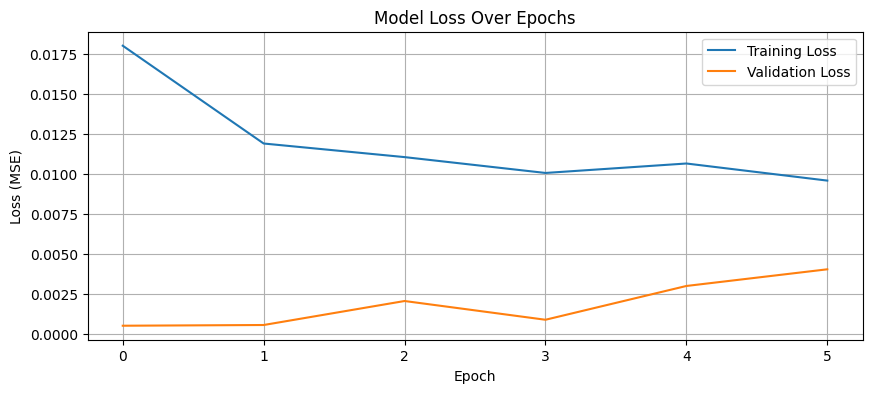

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step
model_2selected_features_2024  | MAE:  3.943  MSE: 23.381  RMSE:  4.835  R²:  0.443


,Label,MAE,MSE,RMSE,R2,cutoff_date,features
0,model_single_feature,24.880787,2045.849692,45.231070,-0.720771,2021-12-31,PVB
1,model_single_feature_war,58.092209,5676.670588,75.343683,-2.988796,2021-12-31,PVB
2,model_single_feature_PostWar,6.891267,79.155040,8.896912,-0.682188,2021-12-31,PVB
3,model_single_feature,5.926961,57.801079,7.602702,-0.228378,2023-03-31,PVB
4,model_all26_features_total,27.978830,2115.007905,45.989215,-0.778940,2021-12-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
5,model_all26_features_War,55.705756,5604.190415,74.861141,-2.539116,2021-12-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
6,model_all26_features_PostWar,12.895922,221.270763,14.875173,-3.580818,2021-12-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
7,model_all26_features_total,20.378255,457.059442,21.378949,-8.713343,2023-03-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
8,model_10selected_features_total,17.832639,737.282812,27.152952,0.379869,2021-12-31,"PVB, JKM_Price, TTF_Price, TTFMc1, TTFMc2, MA_..."
9,model_10selected_features_War,32.238442,1761.246584,41.967208,-0.112249,2021-12-31,"PVB, JKM_Price, TTF_Price, TTFMc1, TTFMc2, MA_..."


In [ ]:
#@title model_2selected_features with cutoff_date 2024-03-31

# Step 1: Scale the features
scaler = MinMaxScaler()
features = df_selected_features[['PVB', 'TTF_Price']]

scaled = scaler.fit_transform(features)


# Define parameters
window_size = 365
horizon_days = 30
cutoff_date = '2024-03-31'
split_idx = df_selected_features.index.get_loc(cutoff_date)
buffer = window_size + horizon_days - 1


# split the data
scaled_train = scaled[:split_idx + 1]     # up to and including cutoff
scaled_test = scaled[split_idx + 1 - buffer:]  # include buffer to allow test sequence generation

# Now safely create sequences
X_train, y_train = create_sequences_multifeature(scaled_train, window_size=window_size, horizon=horizon_days)
X_test, y_test = create_sequences_multifeature(scaled_test, window_size=window_size, horizon=horizon_days)


print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

# Build and Train the LSTM Model

# Build model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),     # First LSTM layer returns sequence
    Dropout(0.4),
    LSTM(32),                            # Second LSTM layer outputs a vector
    Dropout(0.2),
    Dense(1)                             # Predict a single target value
])

model.compile(
    optimizer=Adam(),
    loss='mse',
   metrics=[
        MeanAbsoluteError(name='mae'),
        RootMeanSquaredError(name='rmse'),
        MeanAbsolutePercentageError(name='mape')
    ]
  )
# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',     # Watch this metric
    factor=0.5,             # Reduce LR by half
    patience=3,             # Wait for 3 epochs with no improvement
    verbose=1               # Print updates
)

# Manual chronological split from training set (e.g., last 10% of X_train)
val_size = int(len(X_train) * 0.1)
X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]


# Train model
history = model.fit(X_train_sub, y_train_sub,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, lr_scheduler],
    verbose=1)

plot_loss(history)

#@title Evaluate the model result by inverse y_test and y_pred during  war and post war periods

# After model prediction (in scaled space)
y_pred_scaled = model.predict(X_test)

# Inverse just the price component
y_pred = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=scaled.shape[1])
y_test = inverse_single_feature(scaler, y_test, feature_index=0, total_features=scaled.shape[1])

evaluation_metrics(y_test, y_pred, label = 'model_2selected_features_2024', cutoff_date = cutoff_date, results_df = results_df, features = features.columns.tolist())

In [ ]:
gs_results_df = pd.read_csv('/content/drive/My Drive/BKW/Models/PVB/model_2selected_features_gridsearch.csv')
gs_results_df

,cutoff_date,window_size,horizon_days,lstm1,lstm2,drop1,drop2,mae,rmse,mape,R2
0,2024-03-31,90,30,32,16,0.2,0.1,3.961257,4.872532,10.013022,0.434608
1,2024-03-31,90,30,32,16,0.4,0.2,4.531628,5.275789,11.687860,0.337150
2,2024-03-31,90,30,32,16,0.5,0.3,4.406087,5.211764,11.202897,0.353141
3,2024-03-31,90,30,64,32,0.2,0.1,3.879255,4.761518,9.995692,0.460078
4,2024-03-31,90,30,64,32,0.4,0.2,4.841278,5.639779,12.672427,0.242531
5,2024-03-31,90,30,64,32,0.5,0.3,3.677911,4.880725,9.781659,0.432705
6,2024-03-31,90,60,32,16,0.2,0.1,4.725934,6.305416,12.427401,0.053179
7,2024-03-31,90,60,32,16,0.4,0.2,6.137173,7.165906,15.897333,-0.222877
8,2024-03-31,90,60,32,16,0.5,0.3,4.581986,6.701366,12.373329,-0.069466
9,2024-03-31,90,60,64,32,0.2,0.1,5.180935,7.089645,13.909189,-0.196987


In [ ]:
best_rows = gs_results_df.loc[
    gs_results_df.groupby(['horizon_days'])['R2'].idxmax()
].reset_index(drop=True)
best_rows

,cutoff_date,window_size,horizon_days,lstm1,lstm2,drop1,drop2,mae,rmse,mape,R2
0,2024-03-31,365,30,64,32,0.5,0.3,3.709188,4.597553,9.457112,0.496622
1,2024-03-31,90,60,32,16,0.2,0.1,4.725934,6.305416,12.427401,0.053179
2,2024-03-31,365,90,32,16,0.4,0.2,5.649184,7.170556,15.411488,-0.224464


# Build the best model for 30, 60 and 90 horizon

X_train shape: (1676, 365, 2)
X_test shape: (474, 365, 2)
y_train shape: (1676,)
y_test shape: (474,)
Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 0.0230 - mae: 0.0966 - mape: 4941.5947 - rmse: 0.1498 - val_loss: 0.0011 - val_mae: 0.0304 - val_mape: 27.9935 - val_rmse: 0.0331 - learning_rate: 0.0010
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0104 - mae: 0.0625 - mape: 43539.5820 - rmse: 0.1018 - val_loss: 6.1437e-04 - val_mae: 0.0225 - val_mape: 20.3255 - val_rmse: 0.0248 - learning_rate: 0.0010
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0109 - mae: 0.0625 - mape: 18067.9023 - rmse: 0.1041 - val_loss: 0.0019 - val_mae: 0.0408 - val_mape: 37.6966 - val_rmse: 0.0441 - learning_rate: 0.0010
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0100 - mae: 0.0624 - mape: 3622.2698 - rmse: 0.0997 - val_loss: 8.9099e-04 - val_mae: 0.0271 - val_mape: 24.5515 - val_rmse: 0.0298 - learning_rate: 0.0010
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━

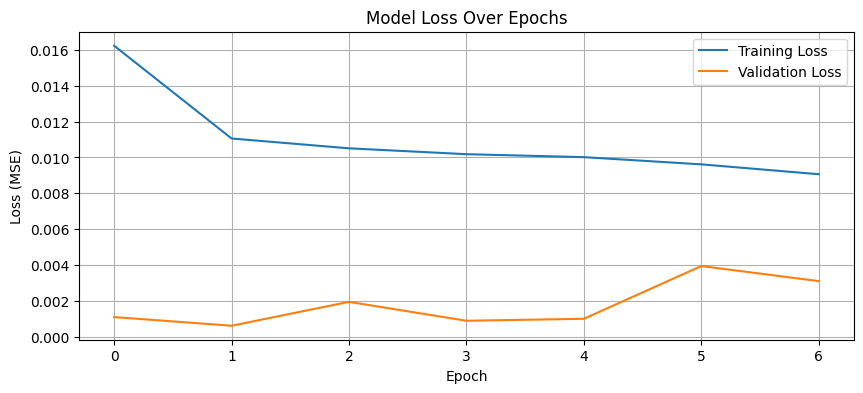

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


{'MAE': 3.8226368668260453,
 'MSE': 24.004408011945415,
 'RMSE': np.float64(4.8994293557459745),
 'R²': 0.4283482636256001}

In [ ]:
#@title model_2selected_features with cutoff_date 2024-03-31 for 30 days horizon
'''
Best parameters:
window_size = 365
horizon_days = 30
lstm1 = 64
lstm2 = 32
drop1 = 0.5
drop2 = 0.3
'''


# Step 1: Scale the features
scaler = MinMaxScaler()
features = df_selected_features[['PVB', 'TTF_Price']]

scaled = scaler.fit_transform(features)


# Define parameters
window_size = 365
horizon_days = 30
cutoff_date = '2024-03-31'
split_idx = df_selected_features.index.get_loc(cutoff_date)
buffer = window_size + horizon_days - 1


# split the data
scaled_train = scaled[:split_idx + 1]     # up to and including cutoff
scaled_test = scaled[split_idx + 1 - buffer:]  # include buffer to allow test sequence generation

# Now safely create sequences
X_train, y_train = create_sequences_multifeature(scaled_train, window_size=window_size, horizon=horizon_days)
X_test, y_test = create_sequences_multifeature(scaled_test, window_size=window_size, horizon=horizon_days)


print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

# Build and Train the LSTM Model

# Build model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),     # First LSTM layer returns sequence
    Dropout(0.5),
    LSTM(32),                            # Second LSTM layer outputs a vector
    Dropout(0.3),
    Dense(1)                             # Predict a single target value
])

model.compile(
    optimizer=Adam(),
    loss='mse',
   metrics=[
        MeanAbsoluteError(name='mae'),
        RootMeanSquaredError(name='rmse'),
        MeanAbsolutePercentageError(name='mape')
    ]
  )
# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',     # Watch this metric
    factor=0.5,             # Reduce LR by half
    patience=3,             # Wait for 3 epochs with no improvement
    verbose=1               # Print updates
)

# Manual chronological split from training set (e.g., last 10% of X_train)
val_size = int(len(X_train) * 0.1)
X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]


# Train model
history = model.fit(X_train_sub, y_train_sub,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, lr_scheduler],
    verbose=1)

plot_loss(history)

#@title Evaluate the model result by inverse y_test and y_pred during  war and post war periods

# After model prediction (in scaled space)
y_pred_scaled = model.predict(X_test)

# Inverse just the price component
y_pred = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=scaled.shape[1])
y_test = inverse_single_feature(scaler, y_test, feature_index=0, total_features=scaled.shape[1])

forecast_metrics(y_test, y_pred)

# evaluation_metrics(y_test, y_pred, label = 'model_2selected_features_30D', cutoff_date = cutoff_date, results_df = results_df, features = features.columns.tolist())

In [ ]:
results_df = results_df[results_df['Label']!= 'model_2selected_features_30D']
results_df.tail()

,Label,MAE,MSE,RMSE,R2,cutoff_date,features
15,model_3selected_features_2023,14.822797,273.805855,16.547080,-4.818872,2023-03-31,"PVB, TTF_Price, bollinger_width"
16,model_2selected_features_2023,4.798740,32.555256,5.705721,0.308142,2023-03-31,"PVB, TTF_Price"
17,model_2selected_features_2024,3.943047,23.380511,4.835340,0.443206,2024-03-31,"PVB, TTF_Price"
18,model_2selected_features_2024_2,4.638995,30.126910,5.488799,0.205436,2024-06-30,"PVB, TTF_Price"
19,model_5selected_features_2024,5.724221,48.920547,6.994323,-0.165016,2024-03-31,"PVB, JKM_Price, TTF_Price, rolling_std_30, bol..."


In [ ]:
evaluation_metrics(y_test, y_pred, label = 'model_2selected_features_30D_best', cutoff_date = cutoff_date, results_df = results_df, features = features.columns.tolist())

model_2selected_features_30D_best | MAE:  3.823  MSE: 24.004  RMSE:  4.899  R²:  0.428


,Label,MAE,MSE,RMSE,R2,cutoff_date,features
0,model_single_feature,24.880787,2045.849692,45.231070,-0.720771,2021-12-31,PVB
1,model_single_feature_war,58.092209,5676.670588,75.343683,-2.988796,2021-12-31,PVB
2,model_single_feature_PostWar,6.891267,79.155040,8.896912,-0.682188,2021-12-31,PVB
3,model_single_feature,5.926961,57.801079,7.602702,-0.228378,2023-03-31,PVB
4,model_all26_features_total,27.978830,2115.007905,45.989215,-0.778940,2021-12-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
5,model_all26_features_War,55.705756,5604.190415,74.861141,-2.539116,2021-12-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
6,model_all26_features_PostWar,12.895922,221.270763,14.875173,-3.580818,2021-12-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
7,model_all26_features_total,20.378255,457.059442,21.378949,-8.713343,2023-03-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
8,model_10selected_features_total,17.832639,737.282812,27.152952,0.379869,2021-12-31,"PVB, JKM_Price, TTF_Price, TTFMc1, TTFMc2, MA_..."
9,model_10selected_features_War,32.238442,1761.246584,41.967208,-0.112249,2021-12-31,"PVB, JKM_Price, TTF_Price, TTFMc1, TTFMc2, MA_..."


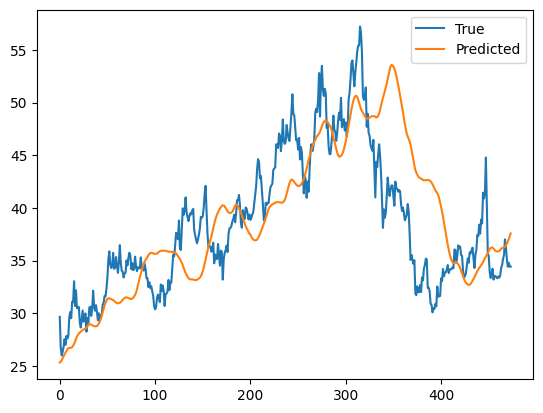

In [ ]:
import matplotlib.pyplot as plt
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [ ]:
save_model_and_history(model,
                       history,
                       save_dir='/content/drive/My Drive/BKW/Models/PVB',
                       model_name='PVB_lstm_model_2selected_features_30D_best')

✅ Model saved to: /content/drive/My Drive/BKW/Models/PVG/PVB_lstm_model_2selected_features_30D_best.keras
✅ History saved to: /content/drive/My Drive/BKW/Models/PVG/PVB_lstm_model_2selected_features_30D_best_history.pkl


In [ ]:
# load the model
model_loaded, history_loaded = load_model_and_history('/content/drive/My Drive/BKW/Models/PVB', model_name='PVB_lstm_model_2selected_features_30D_best')

✅ Model loaded from: /content/drive/My Drive/BKW/Models/PVG/PVB_lstm_model_2selected_features_30D_best.keras
✅ History loaded from: /content/drive/My Drive/BKW/Models/PVG/PVB_lstm_model_2selected_features_30D_best_history.pkl


In [ ]:
#@title Add the y_test and y_pred and save together with the features

test_start_idx = split_idx + 1 - buffer
forecast_made_start_idx = test_start_idx + window_size - 1   # Last day of input sequence
forecast_dates = df_selected_features.index[forecast_made_start_idx : forecast_made_start_idx + len(y_test)]


save_lstm_forecast_results_full(
    forecast_dates,
    features,
    y_pred,
    y_test,
    horizon_days,
    save_path='/content/drive/My Drive/BKW/reports/PVB_forecast/PVB_lstm_model_2selected_features_30D_best.csv')

✅ Forecast results saved to: /content/drive/My Drive/BKW/reports/PVB_forecast/PVB_lstm_model_2selected_features_30D_best.csv


,PVB,TTF_Price,Predicted_30D,Actual_30D
Date,,,,
2018-08-01,25.35,22.13,<NA>,<NA>
2018-08-02,25.30,22.15,<NA>,<NA>
2018-08-03,25.30,22.18,<NA>,<NA>
2018-08-04,25.20,22.28,<NA>,<NA>
2018-08-05,26.75,22.38,<NA>,<NA>
...,...,...,...,...
2025-07-14,35.17,40.03,<NA>,<NA>
2025-07-15,34.42,40.03,<NA>,<NA>
2025-07-16,34.80,40.03,<NA>,<NA>


In [ ]:
#@title Use the model to predict based on the latest available data

# --- CONFIG ---
csv_path = '/content/drive/My Drive/BKW/reports/PVB_forecast/PVB_lstm_model_2selected_features_30D_best.csv'
model_path = '/content/drive/My Drive/BKW/Models/PVB/PVB_lstm_model_2selected_features_30D_best.keras'
window_size = 365          # e.g., 365 days of lookback
horizon_days = 30          # ⬅️ adapt this to 60 or other values as needed
target_feature_index = 0   # u
prediction_col = f'Predicted_{horizon_days}D'

# --- Load Data ---
df = pd.read_csv(csv_path, parse_dates=['Date'], index_col='Date')

# --- Add prediction column if missing ---
if prediction_col not in df.columns:
    df[prediction_col] = np.nan

# --- Define features ---
feature_cols = features.columns.tolist()

# --- Fit Scaler ---
scaler = MinMaxScaler()
scaler.fit(df[feature_cols])

# --- Load Model ---
model = load_model(model_path)

# --- Define forecast range: last `horizon_days` rows ---
start_idx = len(df) - horizon_days

for i in range(start_idx, len(df)):
    t = df.index[i]

    # skip if not enough history
    if i - window_size + 1 < 0:
        continue

    # get and scale window
    window_data = df.iloc[i - window_size + 1 : i + 1][feature_cols].values
    window_scaled = scaler.transform(window_data)
    X_input = window_scaled.reshape(1, window_size, len(feature_cols))

    # predict and inverse transform
    pred_scaled = model.predict(X_input, verbose=0)
    dummy_input = np.zeros((1, len(feature_cols)))
    dummy_input[0, target_feature_index] = pred_scaled[0][0]
    pred_unscaled = scaler.inverse_transform(dummy_input)[0][target_feature_index]

    # store result
    df.loc[t, prediction_col] = pred_unscaled

# --- (Optional) Save result ---
# df.to_csv(csv_path)

# --- Show result ---
df.tail(horizon_days + 1)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMax

,PVB,TTF_Price,Predicted_30D,Actual_30D
Date,,,,
2025-06-18,38.53,39.40,37.580103,34.43
2025-06-19,41.45,41.50,37.943835,NaN
2025-06-20,40.90,40.03,38.339974,NaN
2025-06-21,41.42,40.03,38.760406,NaN
2025-06-22,44.79,40.03,39.295890,NaN
2025-06-23,40.39,40.03,39.749737,NaN
2025-06-24,35.70,40.03,39.970587,NaN
2025-06-25,35.42,40.03,40.004695,NaN
2025-06-26,33.94,40.03,39.853732,NaN


In [ ]:
df.to_csv('/content/drive/My Drive/BKW/reports/PVB_forecast/30d_prediction_model_2selected_features_add_latest_data.csv')

# Using the best model from gridsearch to forecast 60 day prices

In [ ]:
# load the model
model_loaded, history = load_model_and_history('/content/drive/My Drive/BKW/Models/PVB', model_name='best_model_h60')

✅ Model loaded from: /content/drive/My Drive/BKW/Models/PVB/best_model_h60.keras
⚠️ History file not found at: /content/drive/My Drive/BKW/Models/PVB/best_model_h60_history.pkl


In [ ]:
#@title Reproduce the y_test and y_pred using the model loaded
# Step 1: Scale the features
scaler = MinMaxScaler()
features = df_selected_features[['PVB', 'TTF_Price']]

scaled = scaler.fit_transform(features)


# Define parameters
window_size = 180
horizon_days = 60
cutoff_date = '2024-03-31'
split_idx = df_selected_features.index.get_loc(cutoff_date)
buffer = window_size + horizon_days - 1


# split the data
scaled_train = scaled[:split_idx + 1]     # up to and including cutoff
scaled_test = scaled[split_idx + 1 - buffer:]  # include buffer to allow test sequence generation

# Now safely create sequences
X_train, y_train = create_sequences_multifeature(scaled_train, window_size=window_size, horizon=horizon_days)
X_test, y_test = create_sequences_multifeature(scaled_test, window_size=window_size, horizon=horizon_days)

y_pred_scaled = model_loaded.predict(X_test)
y_pred = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=scaled.shape[1])
y_test = inverse_single_feature(scaler, y_test, feature_index=0, total_features=scaled.shape[1])

test_start_idx = split_idx + 1 - buffer
forecast_made_start_idx = test_start_idx + window_size - 1   # Last day of input sequence
forecast_dates = df_selected_features.index[forecast_made_start_idx : forecast_made_start_idx + len(y_test)]

save_lstm_forecast_results_full(
    forecast_dates,
    features,
    y_pred,
    y_test,
    horizon_days,
    save_path='/content/drive/My Drive/BKW/reports/PVB_forecast/PVB_lstm_model_2selected_features_60_forecast.csv'
)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
✅ Forecast results saved to: /content/drive/My Drive/BKW/reports/PVB/PVB_lstm_model_2selected_features_60_forecast.csv


,PVB,TTF_Price,Predicted_60D,Actual_60D
Date,,,,
2018-08-01,25.35,22.13,<NA>,<NA>
2018-08-02,25.30,22.15,<NA>,<NA>
2018-08-03,25.30,22.18,<NA>,<NA>
2018-08-04,25.20,22.28,<NA>,<NA>
2018-08-05,26.75,22.38,<NA>,<NA>
...,...,...,...,...
2025-07-14,35.17,40.03,<NA>,<NA>
2025-07-15,34.42,40.03,<NA>,<NA>
2025-07-16,34.80,40.03,<NA>,<NA>


In [ ]:
#@title Use the model to predict based on the latest available data

# --- CONFIG ---
csv_path = '/content/drive/My Drive/BKW/reports/PVB_forecast/PVB_lstm_model_2selected_features_60_forecast.csv'
model_path = '/content/drive/My Drive/BKW/Models/PVB/best_model_h60.keras'
window_size = window_size          # e.g., 365 days of lookback
horizon_days = horizon_days          # ⬅️ adapt this to 60 or other values as needed
target_feature_index = 0   # u
prediction_col = f'Predicted_{horizon_days}D'

# --- Load Data ---
df = pd.read_csv(csv_path, parse_dates=['Date'], index_col='Date')

# --- Add prediction column if missing ---
if prediction_col not in df.columns:
    df[prediction_col] = np.nan

# --- Define features ---
feature_cols = features.columns.tolist()

# --- Fit Scaler ---
scaler = MinMaxScaler()
scaler.fit(df[feature_cols])

# --- Load Model ---
model = load_model(model_path)

# --- Define forecast range: last `horizon_days` rows ---
start_idx = len(df) - horizon_days

for i in range(start_idx, len(df)):
    t = df.index[i]

    # skip if not enough history
    if i - window_size + 1 < 0:
        continue

    # get and scale window
    window_data = df.iloc[i - window_size + 1 : i + 1][feature_cols].values
    window_scaled = scaler.transform(window_data)
    X_input = window_scaled.reshape(1, window_size, len(feature_cols))

    # predict and inverse transform
    pred_scaled = model.predict(X_input, verbose=0)
    dummy_input = np.zeros((1, len(feature_cols)))
    dummy_input[0, target_feature_index] = pred_scaled[0][0]
    pred_unscaled = scaler.inverse_transform(dummy_input)[0][target_feature_index]

    # store result
    df.loc[t, prediction_col] = pred_unscaled

# --- (Optional) Save result ---
# df.to_csv(csv_path)

# --- Show result ---
df.tail(horizon_days + 1)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMax

,PVB,TTF_Price,Predicted_60D,Actual_60D
Date,,,,
2025-05-19,34.29,35.10,36.338992,34.43
2025-05-20,36.06,37.80,36.453484,NaN
2025-05-21,36.02,36.20,36.588158,NaN
2025-05-22,34.95,36.17,36.708206,NaN
2025-05-23,35.44,36.30,36.825686,NaN
...,...,...,...,...
2025-07-14,35.17,40.03,37.608188,NaN
2025-07-15,34.42,40.03,37.649755,NaN
2025-07-16,34.80,40.03,37.677797,NaN


In [ ]:
df.to_csv('/content/drive/My Drive/BKW/reports/PVB_forecast/60d_prediction_model_2selected_features_add_latest_data.csv')

# Using the best model from gridsearch to forecast 90 day prices

In [ ]:
# load the model
model_loaded, history = load_model_and_history('/content/drive/My Drive/BKW/Models/PVB', model_name='best_model_h90')

✅ Model loaded from: /content/drive/My Drive/BKW/Models/PVB/best_model_h90.keras
⚠️ History file not found at: /content/drive/My Drive/BKW/Models/PVB/best_model_h90_history.pkl


In [ ]:
#@title Reproduce the y_test and y_pred using the model loaded
# Step 1: Scale the features
scaler = MinMaxScaler()
features = df_selected_features[['PVB', 'TTF_Price']]

scaled = scaler.fit_transform(features)


# Define parameters
window_size = 180
horizon_days = 90
cutoff_date = '2024-03-31'
split_idx = df_selected_features.index.get_loc(cutoff_date)
buffer = window_size + horizon_days - 1


# split the data
scaled_train = scaled[:split_idx + 1]     # up to and including cutoff
scaled_test = scaled[split_idx + 1 - buffer:]  # include buffer to allow test sequence generation

# Now safely create sequences
X_train, y_train = create_sequences_multifeature(scaled_train, window_size=window_size, horizon=horizon_days)
X_test, y_test = create_sequences_multifeature(scaled_test, window_size=window_size, horizon=horizon_days)

y_pred_scaled = model_loaded.predict(X_test)
y_pred = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=scaled.shape[1])
y_test = inverse_single_feature(scaler, y_test, feature_index=0, total_features=scaled.shape[1])

test_start_idx = split_idx + 1 - buffer
forecast_made_start_idx = test_start_idx + window_size - 1   # Last day of input sequence
forecast_dates = df_selected_features.index[forecast_made_start_idx : forecast_made_start_idx + len(y_test)]

save_lstm_forecast_results_full(
    forecast_dates,
    features,
    y_pred,
    y_test,
    horizon_days,
    save_path='/content/drive/My Drive/BKW/reports/PVB_forecast/PVB_lstm_model_2selected_features_90_forecast.csv')

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
✅ Forecast results saved to: /content/drive/My Drive/BKW/reports/PVB_forecast/PVB_lstm_model_2selected_features_90_forecast.csv


,PVB,TTF_Price,Predicted_90D,Actual_90D
Date,,,,
2018-08-01,25.35,22.13,<NA>,<NA>
2018-08-02,25.30,22.15,<NA>,<NA>
2018-08-03,25.30,22.18,<NA>,<NA>
2018-08-04,25.20,22.28,<NA>,<NA>
2018-08-05,26.75,22.38,<NA>,<NA>
...,...,...,...,...
2025-07-14,35.17,40.03,<NA>,<NA>
2025-07-15,34.42,40.03,<NA>,<NA>
2025-07-16,34.80,40.03,<NA>,<NA>


In [ ]:
#@title Use the model to predict based on the latest available data

# --- CONFIG ---
csv_path = '/content/drive/My Drive/BKW/reports/PVB_forecast/PVB_lstm_model_2selected_features_90_forecast.csv'
model_path = '/content/drive/My Drive/BKW/Models/PVB/best_model_h90.keras'
window_size = window_size          # e.g., 365 days of lookback
horizon_days = horizon_days          # ⬅️ adapt this to 60 or other values as needed
target_feature_index = 0   # u
prediction_col = f'Predicted_{horizon_days}D'

# --- Load Data ---
df = pd.read_csv(csv_path, parse_dates=['Date'], index_col='Date')

# --- Add prediction column if missing ---
if prediction_col not in df.columns:
    df[prediction_col] = np.nan

# --- Define features ---
feature_cols = features.columns.tolist()

# --- Fit Scaler ---
scaler = MinMaxScaler()
scaler.fit(df[feature_cols])

# --- Load Model ---
model = load_model(model_path)

# --- Define forecast range: last `horizon_days` rows ---
start_idx = len(df) - horizon_days

for i in range(start_idx, len(df)):
    t = df.index[i]

    # skip if not enough history
    if i - window_size + 1 < 0:
        continue

    # get and scale window
    window_data = df.iloc[i - window_size + 1 : i + 1][feature_cols].values
    window_scaled = scaler.transform(window_data)
    X_input = window_scaled.reshape(1, window_size, len(feature_cols))

    # predict and inverse transform
    pred_scaled = model.predict(X_input, verbose=0)
    dummy_input = np.zeros((1, len(feature_cols)))
    dummy_input[0, target_feature_index] = pred_scaled[0][0]
    pred_unscaled = scaler.inverse_transform(dummy_input)[0][target_feature_index]

    # store result
    df.loc[t, prediction_col] = pred_unscaled

# --- (Optional) Save result ---
# df.to_csv(csv_path)

# --- Show result ---
df.tail(horizon_days + 1)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMax

,PVB,TTF_Price,Predicted_90D,Actual_90D
Date,,,,
2025-04-19,34.58,34.862,36.433606,34.43
2025-04-20,35.19,34.668,36.408366,NaN
2025-04-21,35.10,34.474,36.421455,NaN
2025-04-22,32.41,34.280,36.394119,NaN
2025-04-23,32.44,34.220,36.339242,NaN
...,...,...,...,...
2025-07-14,35.17,40.030,37.082206,NaN
2025-07-15,34.42,40.030,37.127563,NaN
2025-07-16,34.80,40.030,37.158594,NaN


In [ ]:
df.to_csv('/content/drive/My Drive/BKW/reports/PVB_forecast/90d_prediction_model_2selected_features_add_latest_data.csv')